In [4]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.ticker import NullLocator
import matplotlib.lines as mlines
%matplotlib inline
from matplotlib import pyplot as plt
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "../../figures/SI/biases"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png",".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

plt.style.use('../../scripts/bursa.mplstyle')

In [5]:
%run ../../scripts/helper.py

In [6]:
data = pd.read_table("../../../data/gex/bcells.obs.tsv.gz")
data = data[data.probable_hq_single_b_cell == True]
data.loc[:,"locus"] = data.locus.fillna("Not Detected")
data.loc[:,"detected"] = data.locus.map({"IGH": "Detected", "Not Detected": "Not Detected"})
data.loc[:,"bcelltype"] = data.celltypist
all_cells = pd.read_table("../../../data/gex/all_cells.obs.tsv.gz")

/tmp/ipykernel_37646/1354146652.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("../../../data/gex/bcells.obs.tsv.gz")
/tmp/ipykernel_37646/1354146652.py:6: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  all_cells = pd.read_table("../../../data/gex/all_cells.obs.tsv.gz")


In [7]:
data['HT_library'] = data['sample_uid'].str.contains("HT")
data['data_from_this_study'] = data.sample_uid.str.contains('TBd')
data['frozen'] = data.sample_uid.str.contains('frozen')

# pre-process / calculate statistics

In [8]:
# Grouping data by specific columns and normalizing the value counts
plot_data = all_cells[all_cells.donor.str.contains('TBd')].groupby(['tissue', 'sample_uid'])['possible_b_cell'].value_counts(normalize=True)

# Filtering data
plot_data = plot_data[plot_data > 0]
plot_data = plot_data.reset_index()
plot_data = plot_data[plot_data['possible_b_cell'] == True]
plot_data['negative_selection'] = ~plot_data['tissue'].str.contains("LN")
plot_data['negative_selection'] = ~plot_data['sample_uid'].str.contains("TBd5_frozen_PB") & plot_data['negative_selection']

# Renaming columns
plot_data = plot_data.rename(columns={'negative_selection': 'negative \nselection'})


In [9]:
## VDJ conditioning bias

# Calculate naive proportions
naive_df = data.groupby(['sample_uid', 'tissue', 'bcelltype']).size().reset_index(name='Naive_Count')
total_count = naive_df.groupby(['sample_uid', 'tissue']).Naive_Count.transform('sum')
naive_df['Naive_Proportion'] = naive_df['Naive_Count'] / total_count

# Calculate proportions conditioned on "Detected"
conditioned_df = data[data['detected'] == 'Detected'].groupby(['sample_uid', 'tissue', 'bcelltype']).size().reset_index(name='Conditioned_Count')
total_conditioned_count = conditioned_df.groupby(['sample_uid', 'tissue']).Conditioned_Count.transform('sum')
conditioned_df['Conditioned_Proportion'] = conditioned_df['Conditioned_Count'] / total_conditioned_count

# Merge the two DataFrames to compare proportions
# You'll need to determine the appropriate columns for merging based on your specific needs
merged_df = pd.merge(naive_df, conditioned_df, how='left', left_on=['sample_uid', 'tissue', 'bcelltype'], right_on=['sample_uid','tissue', 'bcelltype'])

# Calculate the difference between the two sets of proportions
merged_df['Proportion_Difference'] = merged_df['Naive_Proportion'] - merged_df['Conditioned_Proportion']

# Now, merged_df contains both the naive and conditioned proportions, as well as their differences


# Generate Plot

/tmp/ipykernel_37646/942002329.py:30: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=long_df, x='Proportion', y='bcelltype', hue='Condition',


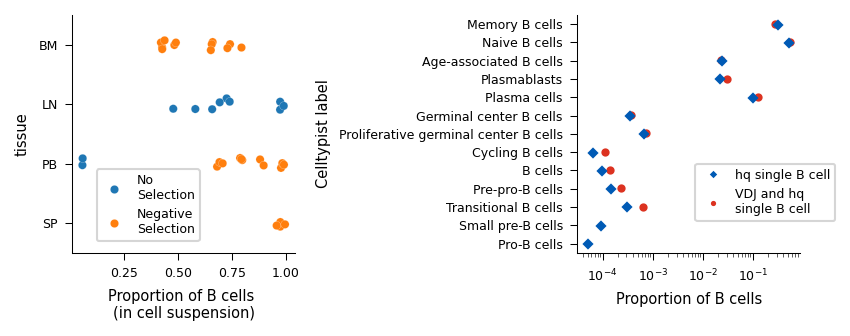

In [10]:
# Melt the DataFrame to long format
color1 = '#005AB5'
color2 = '#DC3220'
long_df = pd.melt(merged_df, id_vars=['sample_uid', 'tissue', 'bcelltype'], 
                  value_vars=['Naive_Proportion', 'Conditioned_Proportion'], 
                  var_name='Condition', value_name='Proportion')
order = data.bcelltype.unique()
# Sort cell types based on the order in the original df
long_df['bcelltype'] = pd.Categorical(long_df['bcelltype'], categories=order, ordered=True)
long_df = long_df.sort_values('bcelltype')
## B Cell Purification

# Create a single figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(6, 2.25), tight_layout = True)
fig.subplots_adjust(wspace=3.5)  # Adjust this value to increase/decrease space between subplots

# Second plot (now on the left)
sns.stripplot(data=plot_data, y='tissue', hue='negative \nselection', x='proportion', size=4, edgecolor='white', linewidth=0.1, palette='tab10', ax=axes[0])

# Legend and other settings for the second plot (now on the left)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ["No\nSelection", "Negative\nSelection"], title=None, loc='right', bbox_to_anchor=(0.6, 0.2))
axes[0].xaxis.set_minor_locator(NullLocator())
axes[0].set_xlabel("Proportion of B cells \n(in cell suspension)")
axes[0].set_ylabel("tissue")
axes[0].set_xscale("linear")
sns.despine(ax=axes[0])

# First plot (now on the right)
sns.pointplot(data=long_df, x='Proportion', y='bcelltype', hue='Condition',
              ax=axes[1], markers=['o', 'D'], scale = 0.8,
              palette={'Naive_Proportion': color1, 'Conditioned_Proportion': color2}, linestyle="", dodge=True, errorbar=None)

# Legend and other settings for the first plot (now on the right)
red_line = mlines.Line2D([], [], color=color1, marker='D', markersize=1.5, label='hq single B cell', linestyle='None')
black_line = mlines.Line2D([], [], color=color2, marker='o', markersize=1.5, label='VDJ and hq\nsingle B cell', linestyle='None')
axes[1].legend(handles=[red_line, black_line], bbox_to_anchor=(0.5, 0.4))
axes[1].set_xscale('log')
axes[1].set_xlabel('Proportion of B cells')
axes[1].set_ylabel('Celltypist label')
axes[1].yaxis.set_minor_locator(NullLocator())
sns.despine(ax=axes[1])

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
data.groupby('HT_library')['bcelltype'].value_counts(normalize=True)

HT_library  bcelltype                            
False       Memory B cells                           0.463368
            Naive B cells                            0.459821
            Plasma cells                             0.043525
            Plasmablasts                             0.021039
            Age-associated B cells                   0.011593
            Proliferative germinal center B cells    0.000515
            Germinal center B cells                  0.000062
            Pre-pro-B cells                          0.000023
            Transitional B cells                     0.000023
            Cycling B cells                          0.000015
            B cells                                  0.000008
            Pro-B cells                              0.000008
True        Memory B cells                           0.471830
            Naive B cells                            0.430719
            Plasma cells                             0.051585
            Age-asso

/tmp/ipykernel_37646/3661276587.py:9: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=ht_data, x='Proportion', y='bcelltype', hue='Condition',


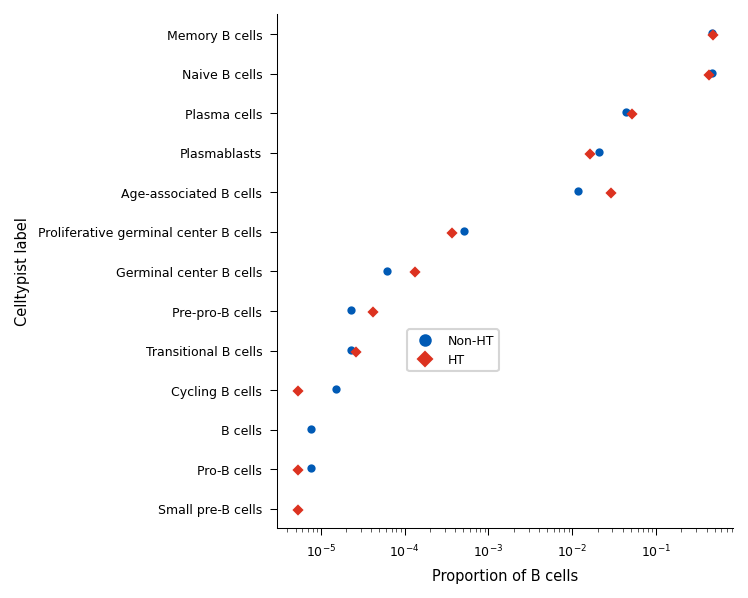

In [19]:
# Prepare the data
ht_data = data.groupby('HT_library')['bcelltype'].value_counts(normalize=True).reset_index(name='Proportion')
ht_data['Condition'] = ht_data['HT_library'].map({False: 'Non-HT', True: 'HT'})

# Create a single figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

# Second plot (right subplot)
sns.pointplot(data=ht_data, x='Proportion', y='bcelltype', hue='Condition',
              ax=ax, markers=['o', 'D'], scale=0.8,
              palette={'Non-HT': color1, 'HT': color2}, 
              linestyle="", dodge=True, errorbar=None)

# Legend and other settings for the second plot
non_ht_line = mlines.Line2D([], [], color=color1, marker='o', markersize=5, label='Non-HT', linestyle='None')
ht_line = mlines.Line2D([], [], color=color2, marker='D', markersize=5, label='HT', linestyle='None')
ax.legend(handles=[non_ht_line, ht_line], bbox_to_anchor=(0.5, 0.4))
ax.set_xscale('log')
ax.set_xlabel('Proportion of B cells')
ax.set_ylabel('Celltypist label')
ax.yaxis.set_minor_locator(NullLocator())
sns.despine(ax=ax)

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure
#save_figure(fig, "gex_bias_and_ht_comparison")

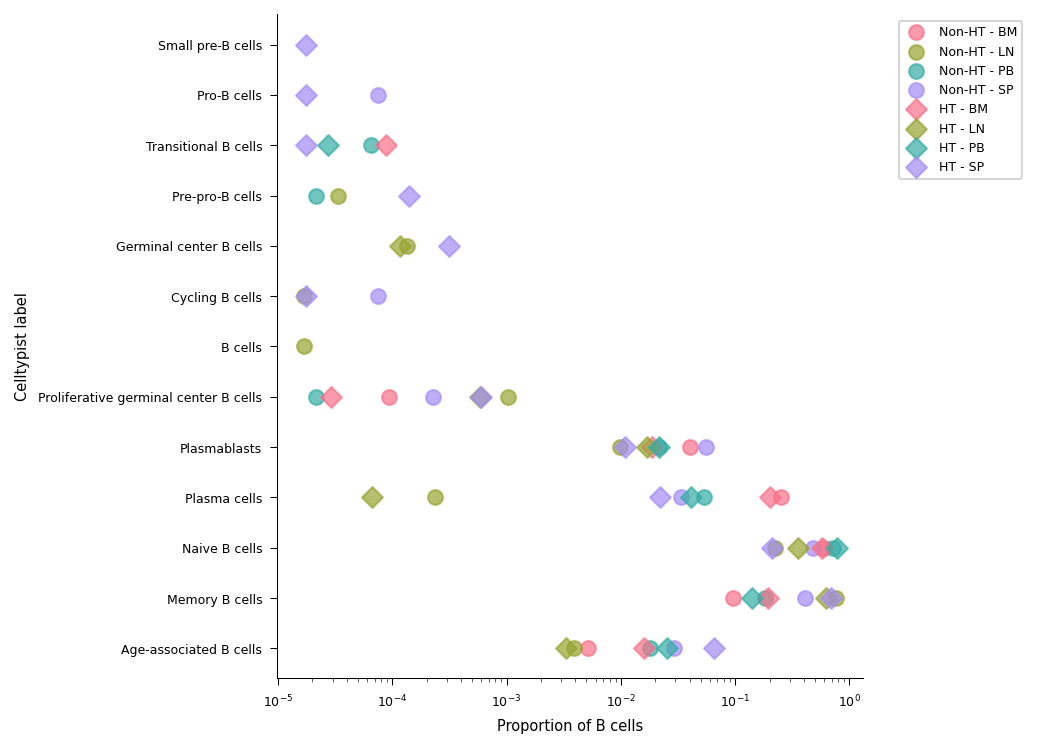

In [21]:
# Prepare the data
ht_data = data.groupby(['HT_library', 'tissue', 'bcelltype']).size().reset_index(name='Count')
ht_data['Proportion'] = ht_data.groupby(['HT_library', 'tissue'])['Count'].transform(lambda x: x / x.sum())
ht_data['Condition'] = ht_data['HT_library'].map({False: 'Non-HT', True: 'HT'})

# Create a color palette for tissues
unique_tissues = ht_data['tissue'].unique()
tissue_palette = sns.color_palette("husl", n_colors=len(unique_tissues))
tissue_color_dict = dict(zip(unique_tissues, tissue_palette))

# Create a single figure
fig, ax = plt.subplots(1, 1, figsize=(7, 5), tight_layout=True)

# Plot points
for condition in ['Non-HT', 'HT']:
    for tissue in unique_tissues:
        data_subset = ht_data[(ht_data['Condition'] == condition) & (ht_data['tissue'] == tissue)]
        marker = 'o' if condition == 'Non-HT' else 'D'
        ax.scatter(data_subset['Proportion'], data_subset['bcelltype'], 
                   c=[tissue_color_dict[tissue]], marker=marker, s=50, 
                   alpha=0.7, label=f"{condition} - {tissue}")

# Set scale and labels
ax.set_xscale('log')
ax.set_xlabel('Proportion of B cells')
ax.set_ylabel('Celltypist label')
ax.yaxis.set_minor_locator(NullLocator())

# Create legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and despine
plt.tight_layout()
sns.despine(ax=ax)

# Show the plot
plt.show()

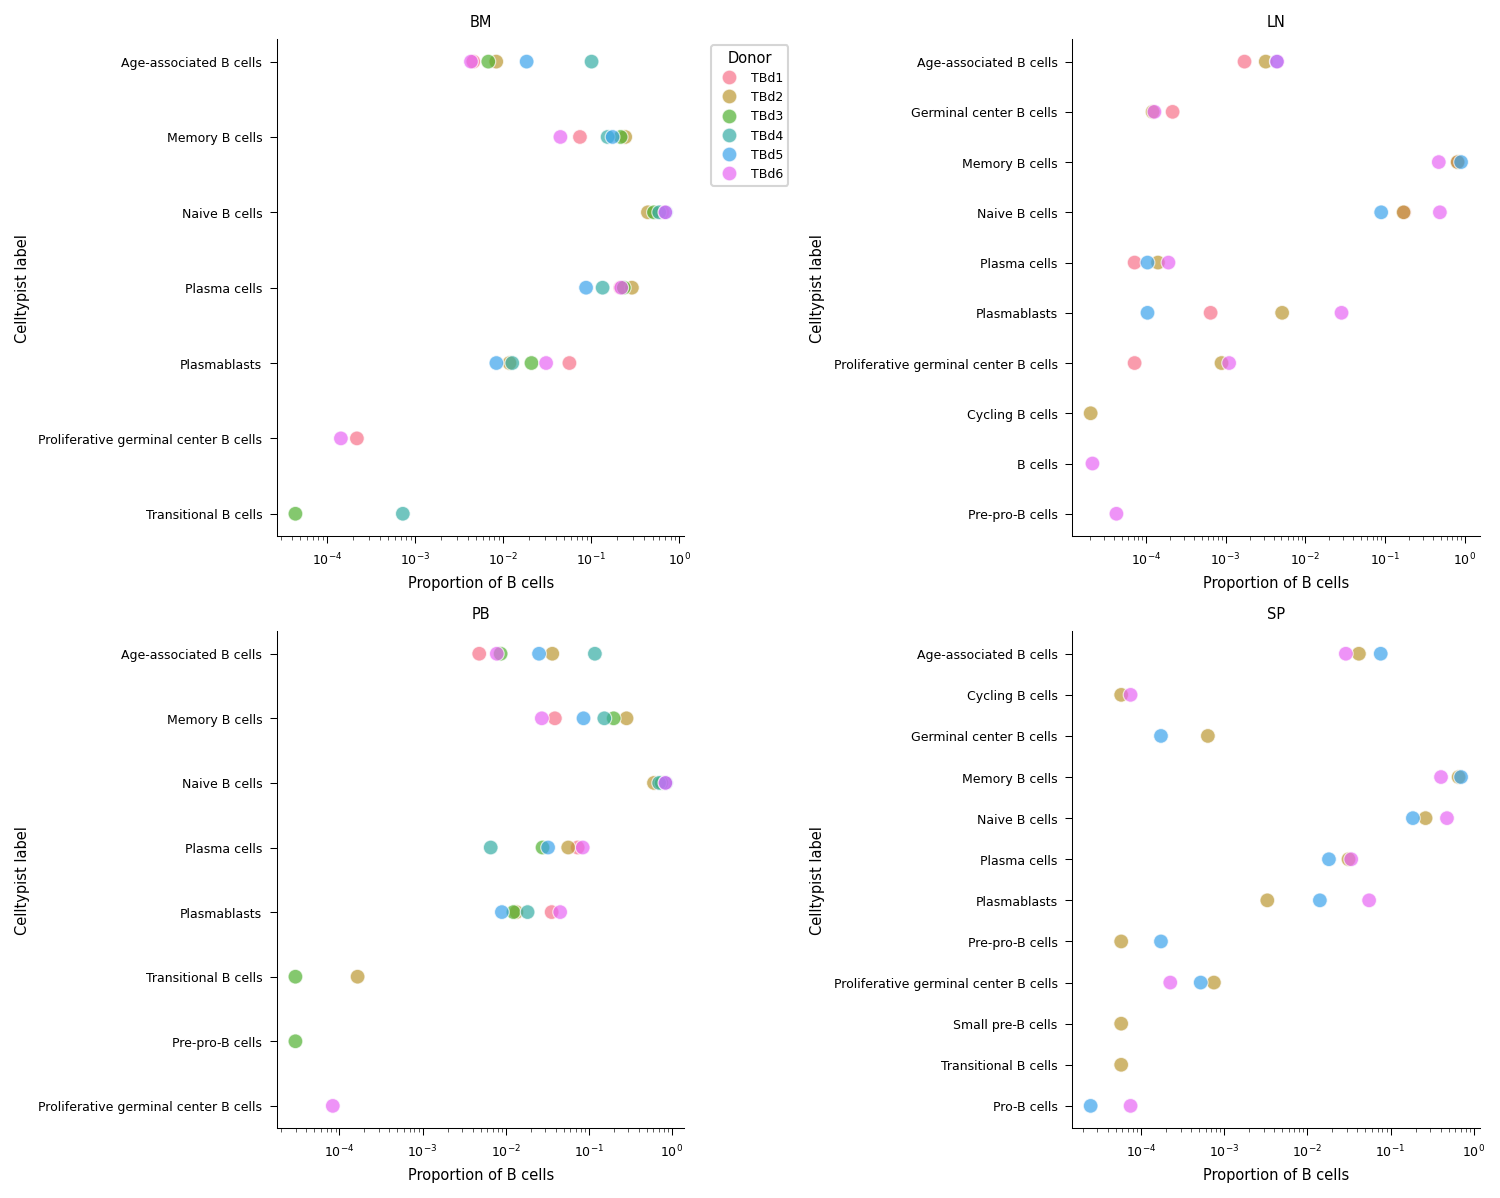

In [24]:
# Prepare the data
ht_data = data.groupby(['donor', 'tissue', 'bcelltype']).size().reset_index(name='Count')
ht_data['Proportion'] = ht_data.groupby(['donor', 'tissue'])['Count'].transform(lambda x: x / x.sum())

# Get unique tissues and donors
unique_tissues = ht_data['tissue'].unique()
unique_donors = ht_data['donor'].unique()

# Create a color palette for donors
donor_palette = sns.color_palette("husl", n_colors=len(unique_donors))
donor_color_dict = dict(zip(unique_donors, donor_palette))

# Calculate grid dimensions
n_cols = 2  # You can adjust this
n_rows = (len(unique_tissues) + n_cols - 1) // n_cols

# Create a figure with subplots for each tissue
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), tight_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, tissue in enumerate(unique_tissues):
    tissue_data = ht_data[ht_data['tissue'] == tissue]
    
    sns.scatterplot(data=tissue_data, x='Proportion', y='bcelltype', hue='donor',
                    ax=axes[i], palette=donor_color_dict, 
                    s=50, alpha=0.7)
    
    axes[i].set_title(tissue)
    axes[i].set_xscale('log')
    axes[i].set_xlabel('Proportion of B cells')
    axes[i].set_ylabel('Celltypist label')
    axes[i].yaxis.set_minor_locator(NullLocator())
    sns.despine(ax=axes[i])
    
    # Adjust legend
    if i == 0:
        axes[i].legend(title='Donor', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[i].legend([],[], frameon=False)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


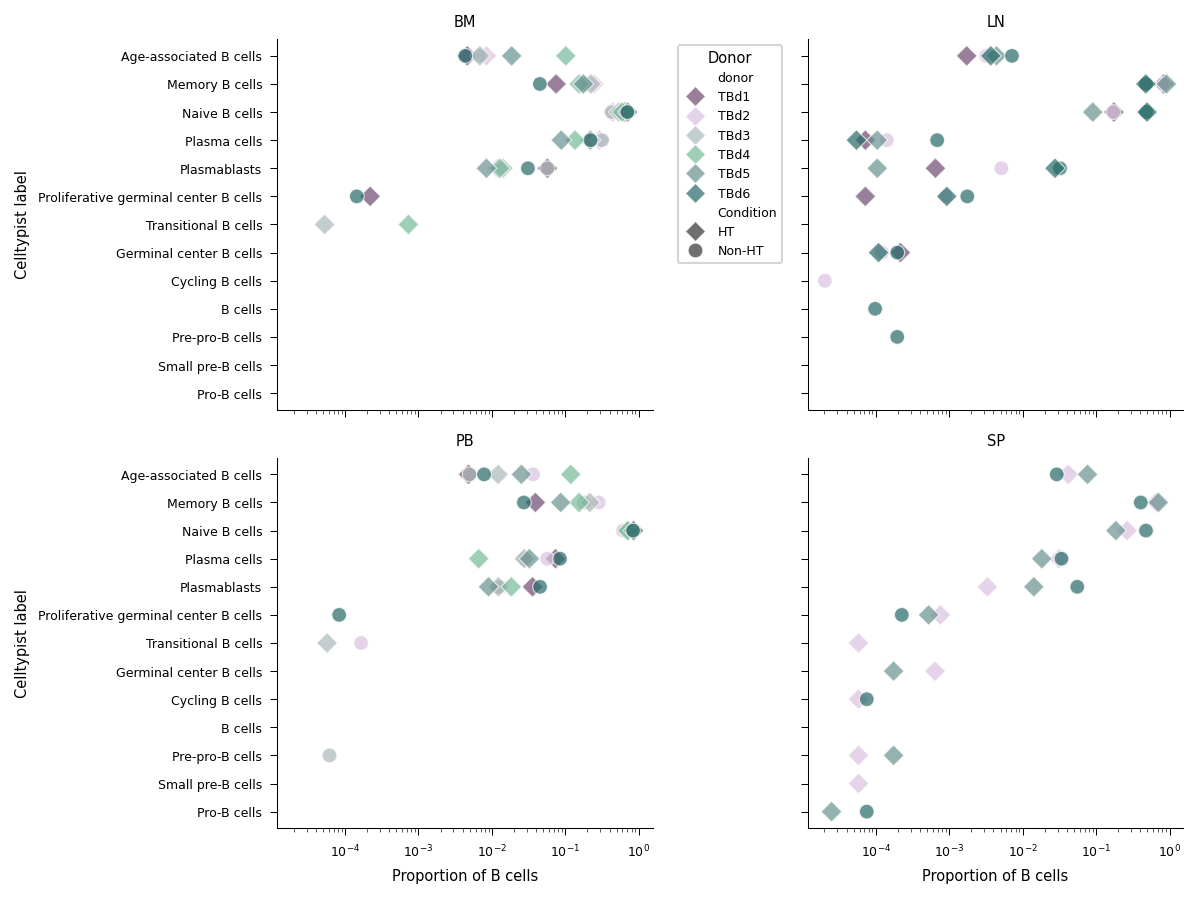

In [45]:
# Prepare the data
from analysis.scripts.global_plot_settings import get_colors


ht_data = data.groupby(['donor', 'HT_library', 'tissue', 'bcelltype']).size().reset_index(name='Count')
ht_data['Proportion'] = ht_data.groupby(['donor', 'HT_library', 'tissue'])['Count'].transform(lambda x: x / x.sum())
ht_data['Condition'] = ht_data['HT_library'].map({False: 'Non-HT', True: 'HT'})

# Get unique tissues and donors
unique_tissues = ht_data['tissue'].unique()
unique_donors = ht_data['donor'].unique()

# Create a color palette for donors
#donor_palette = sns.color_palette("husl", n_colors=len(unique_donors))
#donor_color_dict = dict(zip(unique_donors, donor_palette))
donor_palette = get_colors('donor')
# Calculate grid dimensions
n_cols = 2  # You can adjust this
n_rows = (len(unique_tissues) + n_cols - 1) // n_cols

# Create a figure with subplots for each tissue
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), tight_layout=True, sharey=True, sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, tissue in enumerate(unique_tissues):
    tissue_data = ht_data[ht_data['tissue'] == tissue]
    
    sns.scatterplot(data=tissue_data, x='Proportion', y='bcelltype', hue='donor', style='Condition',
                    ax=axes[i], palette=donor_palette, 
                    markers={'Non-HT': 'o', 'HT': 'D'}, s=50, alpha=0.7)
    
    axes[i].set_title(tissue)
    axes[i].set_xscale('log')
    axes[i].set_xlabel('Proportion of B cells')
    axes[i].set_ylabel('Celltypist label')
    axes[i].yaxis.set_minor_locator(NullLocator())
    sns.despine(ax=axes[i])
    
    # Adjust legend
    if i == 0:
        axes[i].legend(title='Donor', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[i].legend([],[], frameon=False)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# save_figure(fig, "gex_bias_donor_and_ht_comparison_faceted_by_tissue")

/tmp/ipykernel_37646/3566075861.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ht_data = ht_data.groupby(['donor', 'HT_library', 'tissue', 'bcelltype']).apply(calculate_proportion_and_ci).reset_index()


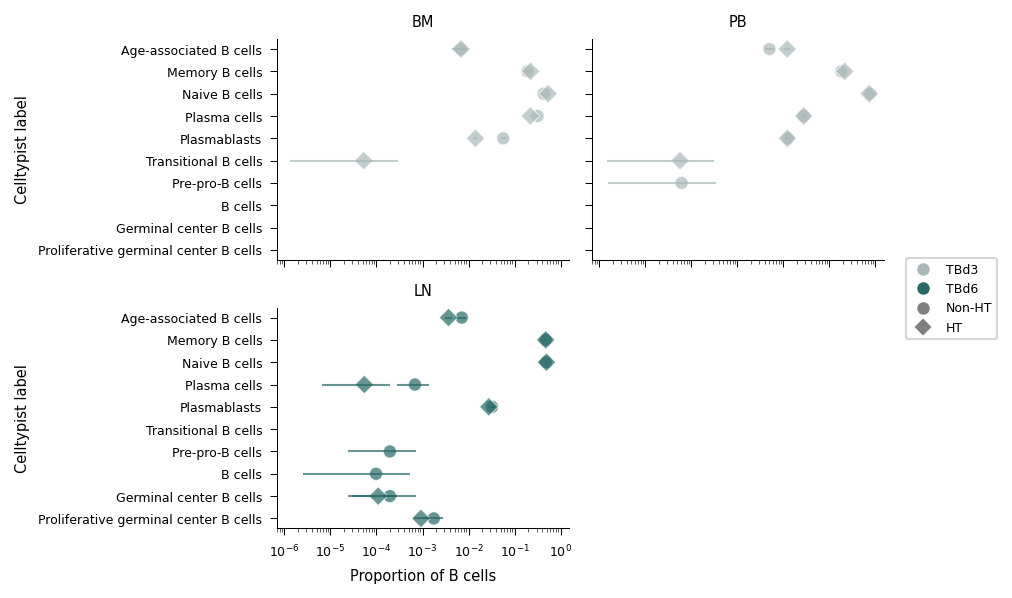

In [44]:
from matplotlib.lines import Line2D
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Helper function to calculate proportion and confidence interval
def calculate_proportion_and_ci(group):
    count = group['Count'].iloc[0]
    total = group['total_in_condition'].iloc[0]
    proportion = count / total
    lower, upper = proportion_confint(count, total, alpha=0.05, method='beta')
    return pd.Series({'Proportion': proportion, 'lower_ci': lower, 'upper_ci': upper})

# Prepare the data
ht_data = data.groupby(['donor', 'HT_library', 'tissue', 'bcelltype']).size().reset_index(name='Count')
ht_data['total_in_condition'] = ht_data.groupby(['donor', 'HT_library', 'tissue'])['Count'].transform('sum')
ht_data = ht_data.groupby(['donor', 'HT_library', 'tissue', 'bcelltype']).apply(calculate_proportion_and_ci).reset_index()
ht_data['Condition'] = ht_data['HT_library'].map({False: 'Non-HT', True: 'HT'})

# Filter to keep only donor-tissue combinations observed in both HT conditions
donor_tissue_counts = ht_data.groupby(['donor', 'tissue', 'Condition']).size().unstack()
donor_tissue_both = donor_tissue_counts[donor_tissue_counts['HT'].notna() & donor_tissue_counts['Non-HT'].notna()].reset_index()
ht_data = ht_data.merge(donor_tissue_both[['donor', 'tissue']], on=['donor', 'tissue'])

# Get unique tissues and donors
unique_tissues = ht_data['tissue'].unique()
unique_donors = ht_data['donor'].unique()

# Use the get_donor_colors function
donor_palette = get_colors('donor')

# Calculate grid dimensions
n_cols = 2  # You can adjust this
n_rows = (len(unique_tissues) + n_cols - 1) // n_cols

# Create a figure with subplots for each tissue
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows), tight_layout=True, sharey=True, sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, tissue in enumerate(unique_tissues):
    tissue_data = ht_data[ht_data['tissue'] == tissue]
    
    sns.scatterplot(data=tissue_data, x='Proportion', y='bcelltype', hue='donor', style='Condition',
                    ax=axes[i], palette=donor_palette, 
                    markers={'Non-HT': 'o', 'HT': 'D'}, s=40, alpha=0.7)
    
    # Add error bars
    for _, row in tissue_data.iterrows():
        axes[i].hlines(row['bcelltype'], row['lower_ci'], row['upper_ci'], 
                       colors=donor_palette[row['donor']], linewidths=1, alpha=0.7)
    
    axes[i].set_title(tissue)
    axes[i].set_xscale('log')
    axes[i].set_xlabel('Proportion of B cells')
    axes[i].set_ylabel('Celltypist label')
    axes[i].yaxis.set_minor_locator(NullLocator())
    sns.despine(ax=axes[i])
    
    # Remove individual legends
    axes[i].legend([],[], frameon=False)

# Create a custom legend
legend_elements = []
for donor in unique_donors:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=donor,
                           markerfacecolor=donor_palette[donor], markersize=7))
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Non-HT',
                       markerfacecolor='gray', markersize=7))
legend_elements.append(Line2D([0], [0], marker='D', color='w', label='HT',
                       markerfacecolor='gray', markersize=7))

# Add the custom legend to the figure
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()